# Single qubit gates in a lattice

In this notebook we show how to perform single qubit gates in a lattice of Rydberg Atoms

In [1]:
import tensorflow as tf

2024-04-15 17:48:00.520366: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 17:48:00.544644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 17:48:00.687619: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 17:48:00.689468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 17:48:01.584771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
sim_res = 2e9
awg_res = 5e8

In [3]:
from qruise.toolset.libraries.rydberg.lattice import SquareLattice
r12 = 4.0
lattice = SquareLattice(n_side=2, r_interatomic=r12)
lattice.draw()

Create the Rydberg systems consisting of Rydberg atom components coupled via Van Der Walls interactions.

In [4]:
from qruise.toolset.libraries.rydberg.rydbergsystem import RydbergSystem
hilbert_dim = 3
ryd_system = RydbergSystem(lattice=lattice, hilbert_dim=hilbert_dim)

In [5]:
ryd_system.rydberg_atom_list

[RydbergAtom(name='0', detuning=0.000 2pi Hz),
 RydbergAtom(name='1', detuning=0.000 2pi Hz),
 RydbergAtom(name='2', detuning=0.000 2pi Hz),
 RydbergAtom(name='3', detuning=0.000 2pi Hz)]

In [6]:
import numpy as np
from qruise.toolset.objects import Quantity
phase_y = Quantity(value=0.5 * np.pi, unit="rads")
phase_x = Quantity(value=0.0, unit="rads")

In [7]:
for atom in ryd_system.rydberg_atom_list:
    name = atom.name
    ryd_system.add_drive(
    "amplitude-phase",
    f"rx{name}",
    channel="raman",
    connected=[name],
    phase=phase_x,
)
    ryd_system.add_drive(
    "amplitude-phase",
    f"ry{name}",
    channel="raman",
    connected=[name],
    phase=phase_y,
)
    ryd_system.add_drive(
        "amplitude-phase",
        f"rydbergx{name}",
        channel="rydberg",
        connected=[name],
        phase=phase_x,
    )


In [8]:
rabi_amplitude = 2.e6 # MHz
t_pi = np.round(1 / (2 * rabi_amplitude) * 1e9) * 1e-9
t_pi_quantity = Quantity(value=t_pi, unit="s")

In [9]:
t_pi

2.5000000000000004e-07

Create a circuit using qiskit library

In [10]:
# Qiskit related modules
from qruise.qiskit.gates import RX90pGate, RY90pGate
from qiskit import QuantumCircuit

circuit = QuantumCircuit(4)
# circuit.append(RX90pGate(), [0])
# circuit.append(RY90pGate(), [1])
circuit.cz(0, 2)
circuit.draw()

q_0: ─■─
      │ 
q_1: ─┼─
      │ 
q_2: ─■─
        
q_3: ───

In [11]:
for c in circuit:
    print(c.operation)
    print(c.qubits[0]._index)
    print(c.qubits[1]._index)

Instruction(name='cz', num_qubits=2, num_clbits=0, params=[])
0
2


In [12]:
from qruise_utils import create_instructions, name_rx_gate, name_ry_gate, name_cz_gate

In [13]:
gates_list = create_instructions(rydberg_system=ryd_system, circuit=circuit, rabi_amplitude=rabi_amplitude)

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 02. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 1. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 2. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 3. Use set_ideal() explicitly.



In [14]:
gates_list

[Instruction(cz_02_1[0,2]),
 Instruction(cz_02_2[0,2]),
 Instruction(cz_02_3[0,2])]

In [15]:
ryd_system.create_model()

In [16]:
ryd_system.create_experiment()

I am in invalidate_propagators


In [17]:
sequence = [gate.get_key() for gate in gates_list]

In [18]:
sequence

['cz_02_1[0,2]', 'cz_02_2[0,2]', 'cz_02_3[0,2]']

In [21]:
ryd_system.experiment.draw_dynamics(sequence=sequence, state=ryd_system.model.get_state_of_label((0,0,1,0)))

Compute the final state with qiskit

In [ ]:
from qiskit.quantum_info import Statevector
ideal_results = Statevector.from_instruction(circuit).probabilities_dict()
print(ideal_results)

{'0000': 1.0}


Due to the flip_label qiskit convention, the results seem wrong bu they are correct.

Now we simulate the same circuit with the qruise_backend

In [ ]:
import copy
qruise_experiment = copy.deepcopy(ryd_system.experiment)

In [ ]:
from qruise.toolset.qiskit import QruiseProvider
from qruise.toolset.libraries.rydberg import RydbergAtom


In [ ]:
qruise_provider = QruiseProvider()
qruise_backend = qruise_provider.get_backend("qruise_qasm_rydberg_simulator")
# Set qubit type to Rydberg atom
qruise_backend.qubit_type = RydbergAtom
qruise_backend.set_qruise_experiment(qruise_experiment)

I am in invalidate_propagators
I am in invalidate_propagators
I am in invalidate_propagators
Out {'gate': 'cz', 'name': 'cz_02_1[0,2]', 'parameters': [{'date': '2024-04-15T17:45:33.762425', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:45:33.762425', 'name': 'gate_duration', 'unit': 's', 'value': 2.5000000000000004e-07}], 'qubits': [0, 2]}
Out {'gate': 'cz', 'name': 'cz_02_2[0,2]', 'parameters': [{'date': '2024-04-15T17:45:33.762425', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:45:33.762425', 'name': 'gate_duration', 'unit': 's', 'value': 5.000000000000001e-07}], 'qubits': [0, 2]}
Out {'gate': 'cz', 'name': 'cz_02_3[0,2]', 'parameters': [{'date': '2024-04-15T17:45:33.762425', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:45:33.762425', 'name': 'gate_duration', 'unit': 's', 'value': 2.5000000000000004e-07}], 'qubits': [0, 2]}
Out {'gate': 'rz', 'name': 'rz[0]', 'parameters': [{'date': '2024-04-15T17:45:33

In [ ]:
qruise_backend.qruise_exp.propagators

{'cz_02_2[0,2]': TensorPropagator(Instruction(cz_02_2[0,2])),
 'cz_02_1[0,2]': TensorPropagator(Instruction(cz_02_1[0,2])),
 'cz_02_3[0,2]': TensorPropagator(Instruction(cz_02_3[0,2]))}

In [ ]:
def state_transform_function() -> callable:
    def state_transform(
        state: tf.Tensor, gate_dict: dict, reshape_after: bool, reshape_before: bool
    ):
        # Gate dict name
        gate_name = gate_dict["name"]
        if gate_name == "cz":
            atom1 = gate_dict["qubits"][0]
            atom2 = gate_dict["qubits"][1]
            gate_dict["name"] = name_cz_gate(atom1, atom2)
            for pulse_index in [1, 2, 3]:
                reshape_after = (
                None if reshape_after is None and pulse_index == 3 else False
                )
                state = qruise_experiment.lookup_propagator(
                    **gate_dict,
                    compute=False,
                    gate_index=f"_{str(pulse_index)}",
                ).propagate_state(
                    state, reshape_after=reshape_after, reshape_before=reshape_before
                )
                reshape_before = False
        else:
            print("Gate dict", gate_dict)
            angle = gate_dict["params"][0]
            atom = gate_dict["qubits"][0]
            gate_dict["name"] = name_rx_gate(angle, atom) if "rx" in gate_name else name_ry_gate(angle, atom)
            state = qruise_experiment.lookup_propagator(
                **gate_dict,
                compute=False,
            ).propagate_state(
                state, reshape_after=reshape_after, reshape_before=reshape_before
            )
        return state

    return state_transform

In [ ]:
qruise_backend._state_propagation_function = state_transform_function()

In [ ]:
circuit.measure_all()

In [ ]:
circuit.draw()

░ ┌─┐         
   q_0: ─■──░─┤M├─────────
         │  ░ └╥┘┌─┐      
   q_1: ─┼──░──╫─┤M├──────
         │  ░  ║ └╥┘┌─┐   
   q_2: ─■──░──╫──╫─┤M├───
            ░  ║  ║ └╥┘┌─┐
   q_3: ────░──╫──╫──╫─┤M├
            ░  ║  ║  ║ └╥┘
meas: 4/═══════╩══╩══╩══╩═
               0  1  2  3

In [ ]:
results = qruise_backend.run(circuit, shots=1000, memory=True)

Is propagator None? False
Is propagator None? False
Is propagator None? False
Meas_index [2, 3, 4, 5]
Pops array [9.99938819e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.32254081e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.17492982e-28 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.

In [ ]:
results.result().data()

{'counts': {'0x0': 1000,
  '0x8': 0,
  '0x4': 0,
  '0xc': 0,
  '0x2': 0,
  '0xa': 0,
  '0x6': 0,
  '0xe': 0,
  '0x1': 0,
  '0x9': 0,
  '0x5': 0,
  '0xd': 0,
  '0x3': 0,
  '0xb': 0,
  '0x7': 0,
  '0xf': 0},
 'state_pops': {'(0, 0, 0, 0)': 0.99993881885598,
  '(0, 0, 0, 1)': 0.0,
  '(0, 0, 0, 2)': 0.0,
  '(0, 0, 1, 0)': 0.0,
  '(0, 0, 1, 1)': 0.0,
  '(0, 0, 1, 2)': 0.0,
  '(0, 0, 2, 0)': 4.3225408116838675e-09,
  '(0, 0, 2, 1)': 0.0,
  '(0, 0, 2, 2)': 0.0,
  '(0, 1, 0, 0)': 0.0,
  '(0, 1, 0, 1)': 0.0,
  '(0, 1, 0, 2)': 0.0,
  '(0, 1, 1, 0)': 0.0,
  '(0, 1, 1, 1)': 0.0,
  '(0, 1, 1, 2)': 0.0,
  '(0, 1, 2, 0)': 0.0,
  '(0, 1, 2, 1)': 0.0,
  '(0, 1, 2, 2)': 0.0,
  '(0, 2, 0, 0)': 0.0,
  '(0, 2, 0, 1)': 0.0,
  '(0, 2, 0, 2)': 0.0,
  '(0, 2, 1, 0)': 0.0,
  '(0, 2, 1, 1)': 0.0,
  '(0, 2, 1, 2)': 0.0,
  '(0, 2, 2, 0)': 0.0,
  '(0, 2, 2, 1)': 0.0,
  '(0, 2, 2, 2)': 0.0,
  '(1, 0, 0, 0)': 0.0,
  '(1, 0, 0, 1)': 0.0,
  '(1, 0, 0, 2)': 0.0,
  '(1, 0, 1, 0)': 0.0,
  '(1, 0, 1, 1)': 0.0,
  '(1, 0, 1,

In [ ]:
[label for label in qruise_experiment.pmap.model.index_labels if all(np.asarray(label) < 2)]

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

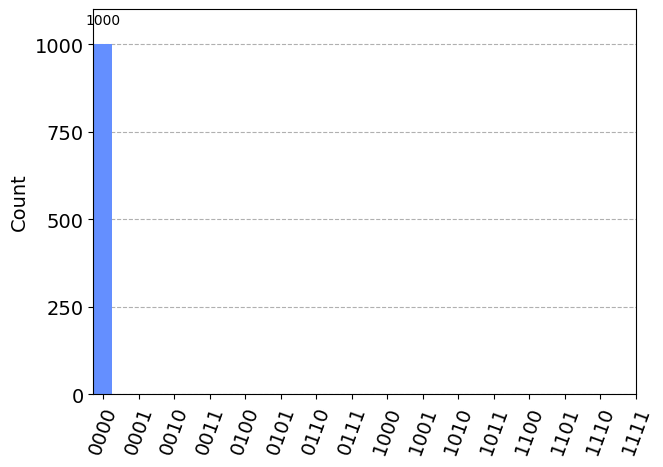

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(results.result().get_counts())

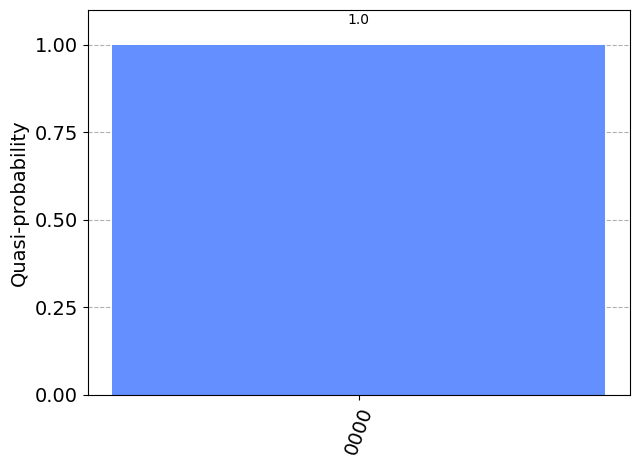

In [ ]:
plot_histogram(ideal_results)